# Sensor Network Localization

Data taken from Example 3 of [this article](https://amstat.tandfonline.com/doi/abs/10.1080/10618600.2017.1415911) (also available on arxiv). The paper studies how to compute posterior distributions for multimodal posteriors, a topic in Bayesian statistics. We have not covered Bayesian statistics yet. We will focus on just maximizing the likelihood.

[Another article](http://ieeexplore.ieee.org/document/1413473/?reload=true) on self localization in sensor networks. 

Example 3 studies the problem of locating sensors in a network. In this network there are $6$ sensors in 2-dimensional space. The x,y coordinates of these sensors is given by the $X$ matrix.

In [125]:
X <- cbind(c(0.57,0.10,0.26,0.85,0.50,0.30),c(0.91,0.37,0.14,0.04,0.30,0.70))
nrow(X)
X

[1] 6

0.57,0.91
0.10,0.37
0.26,0.14
0.85,0.04
0.50,0.30
0.30,0.70


The article treats the location of the first 4 of these sensors as unknown and the location of the sensors 5 and 6 as known. This means that there are 8 total parameters (x,y positions of the 4 unknown parameters).

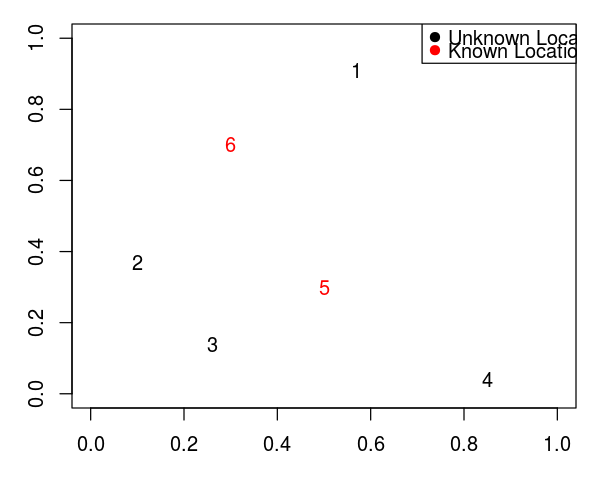

In [126]:
## Roughly reproduces Figure 4 in paper
options(repr.plot.width=5,repr.plot.height=4)
par(mar=c(3,3,1,1))
plot(X[,1],X[,2],xlim=c(0,1),ylim=c(0,1),pch=as.character(1:6),col=c(rep(1,4),rep(2,2)),xlab="",ylab="")
legend("topright",c("Unknown Location","Known Location"),col=c("black","red"),pch=19)

The $Y_{ij}$ entry of matrix $Y$ stores the recorded distance between sensors $i$ and $j$. If no distance is recorded between $i$ and $j$, $Y_{ij} = 0$ (missing data indicator). $Y$ is a symmetric matrix. We initially just input these distances in the upper triangle of $Y$ and then add the transpose to fill out the matrix.

In [127]:
Y <- matrix(c(0,0,0,0.9266,0.6103,0.3631,
              0,0,0.2970,0.8524,0,0,
              0,0,0,0,0.2995,0.5656,
              0,0,0,0,0,0,
              0,0,0,0,0,0,
              0,0,0,0,0,0),nrow=6,byrow=TRUE)
Y <- Y + t(Y)
Y

0.0000,0.0000,0.0000,0.9266,0.6103,0.3631
0.0000,0.0000,0.2970,0.8524,0.0000,0.0000
0.0000,0.2970,0.0000,0.0000,0.2995,0.5656
0.9266,0.8524,0.0000,0.0000,0.0000,0.0000
0.6103,0.0000,0.2995,0.0000,0.0000,0.0000
0.3631,0.0000,0.5656,0.0000,0.0000,0.0000


We now have all the data loaded. The plot in the paper which summarizes the data is:

(requires internet connection to view)

<img src="https://longjp.github.io/statcomp/lectures/optimization_sensor.png">

## Model and Likelihood Function

We observe "noisy" distance estimates between pairs of sensors. Further, there is a probability that no distance measurement is made. The probability is proportional to the distance between the two sensors.

Let $x_{i} = (x_{i1},x_{i2})$ be the Cartesian coordinates of sensor $i$. This data is stored in the rows of the matrix `X`.

Let $W_{ij} = 1$ if a measurement is made between sensors $i$ and $j$ and $0$ if not. The article assumes
$$ W_{ij} \sim Bernoulli(e^{-||x_i - x_j||^2/(2*.3^2)})$$.

Given that a measurement is made, there is normal measurement error
$$ y_{ij} | w_{ij}=1 \sim N(||x_i-x_j||,.02^2).$$
On average the measurement is correct. The standard deviation of the measurement is $0.02$.



In [128]:
## create the W matrix
W <- 1*(Y!=0)
W

0,0,0,1,1,1
0,0,1,1,0,0
0,1,0,0,1,1
1,1,0,0,0,0
1,0,1,0,0,0
1,0,1,0,0,0


In [129]:
## create a matrix of the positions for the known sensors
Xk <- X[5:6,]

In [130]:
## this is L(x_1,x_2,x_3,x_4) above Equation 12 in paper
## note there is a typo in the paper, first exp should be
## to the W_ij power. corrected in this code
likelihood <- function(theta,Xk,Y){
    thetaX <- rbind(matrix(theta,nrow=length(theta)/2,byrow=TRUE),Xk)
    Xd <- as.matrix(dist(thetaX))
    temp <- -Xd^2 / (2*.3^2)
    out <- W*(-(Y - Xd)^2 / (2*0.02^2) + temp) + (1-W)*log(1-exp(temp))
    return(sum(out[lower.tri(out)]))
}

## Fit with BFGS, Numerically Approximated Gradient

Run with random starting location. Check for convergence with `a$convergence` where `a` is the output from `optim`.

In [131]:
## random initial start
init <- runif(8)
## allow for many iterations
maxit <- 1000

In [132]:
a = optim(init,likelihood,method="BFGS",Xk=Xk,Y=Y,control=list(maxit=maxit,fnscale=-1),hessian=TRUE)
summary(a)

            Length Class  Mode   
par          8     -none- numeric
value        1     -none- numeric
counts       2     -none- numeric
convergence  1     -none- numeric
message      0     -none- NULL   
hessian     64     -none- numeric

In [133]:
a$convergence

[1] 0

In [134]:
Xhat <- matrix(a$par,ncol=2,byrow=TRUE)

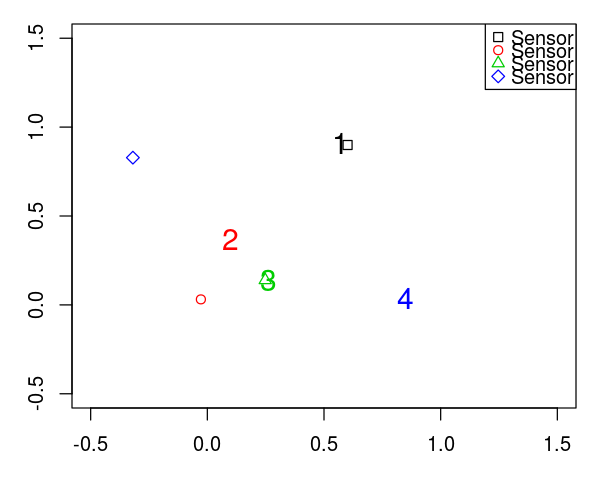

In [135]:
options(repr.plot.width=5,repr.plot.height=4)
pch_est <- c(0,1,2,5)
par(mar=c(3,3,1,1))
plot(Xhat[,1],Xhat[,2],col=1:4,xlab="",ylab="",
    xlim=c(-.5,1.5),ylim=c(-.5,1.5),pch=pch_est)
points(X[1:4,1],X[1:4,2],col=1:4,cex=1.5,pch=as.character(1:4),font=1)
legend("topright",paste0("Sensor ",1:4),col=1:4,pch=pch_est)

In [136]:
## convergence = 0 is good
## convergence = 1 indicates maximum number of iterations reached
a$convergence

[1] 0

## Compute Uncertainties

In [137]:
a$hessian

-4.311051e+03,-1762.7933078,0.0637766,0.1140265,9.452329e-02,0.6971049,2496.1513331,193.2050132
-1.762793e+03,-3223.0553369,0.1140265,0.1387508,6.971049e-01,1.2722176,193.2050132,15.8633634
6.377660e-02,0.1140265,-2477.4215656,-48.2601602,2.175986e+03,853.0093079,296.4258569,-809.6201185
1.140265e-01,0.1387508,-48.2601602,-2557.2187607,8.530093e+02,339.8099662,-809.6201185,2215.1375074
9.452329e-02,0.6971049,2175.9857658,853.0093079,-3.984085e+03,-2219.7817496,0.3530649,-0.5926825
6.971049e-01,1.2722176,853.0093079,339.8099662,-2.219782e+03,-3561.2811772,-0.5926825,0.5849765
2.496151e+03,193.2050132,296.4258569,-809.6201185,3.530649e-01,-0.5926825,-2798.4115979,618.6219391
1.932050e+02,15.8633634,-809.6201185,2215.1375074,-5.926825e-01,0.5849765,618.6219391,-2230.6304600


In [138]:
avar <- solve(-a$hessian)
avar

9.516099e-04,-4.654685e-04,-1.234329e-04,3.111672e-04,-1.437619e-06,1.008860e-06,8.621465e-04,0.0006720199
-4.654685e-04,5.394197e-04,3.274443e-05,-8.241852e-05,4.003402e-07,-1.416340e-07,-4.042024e-04,-0.0002423089
-1.234329e-04,3.274443e-05,2.818998e-02,-6.848560e-02,9.679529e-04,-3.994943e-04,5.745921e-03,-0.0766589515
3.111672e-04,-8.241852e-05,-6.848560e-02,1.729261e-01,-7.402120e-04,5.918137e-04,-1.443499e-02,0.1926057730
-1.437619e-06,4.003402e-07,9.679529e-04,-7.402120e-04,8.144879e-04,-3.466490e-04,8.027320e-05,-0.0010645617
1.008860e-06,-1.416340e-07,-3.994943e-04,5.918137e-04,-3.466490e-04,4.577762e-04,-5.406376e-05,0.0007180069
8.621465e-04,-4.042024e-04,5.745921e-03,-1.443499e-02,8.027320e-05,-5.406376e-05,2.417567e-03,-0.0156780179
6.720199e-04,-2.423089e-04,-7.665895e-02,1.926058e-01,-1.064562e-03,7.180069e-04,-1.567802e-02,0.2152490916


In [139]:
## useful for drawing ellipses on plots
library(ellipse)

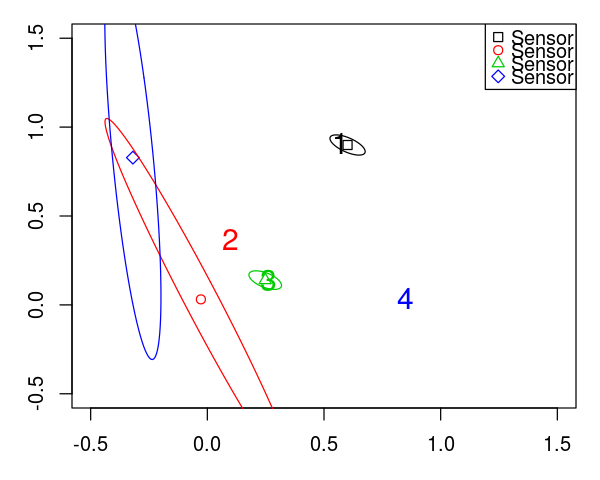

In [140]:
options(repr.plot.width=5,repr.plot.height=4)
pch_est <- c(0,1,2,5)
par(mar=c(3,3,1,1))
plot(Xhat[,1],Xhat[,2],col=1:4,xlab="",ylab="",
    xlim=c(-.5,1.5),ylim=c(-.5,1.5),pch=pch_est)
points(X[1:4,1],X[1:4,2],col=1:4,cex=1.5,pch=as.character(1:4),font=1)
legend("topright",paste0("Sensor ",1:4),col=1:4,pch=pch_est)
for(jj in 1:4){
    v <- avar[(2*jj-1):(2*jj),(2*jj-1):(2*jj)]
    points(ellipse(centre=Xhat[jj,],v,level=0.95),type='l',col=jj)
}

** Potential Problem / Challenge: ** The parameter values are converging to different values depending on starting point. Also the uncertainty ellipses are not capturing the true values as often as we would expect.

## Explore Convergence of BFGS

We now explore how BFGS is converging by running the algorithm $N$ times at different randomly chosen starting positions.

## Max 30 Iterations

In [141]:
## we run the optimizer N times from
## random starting locations
N <- 500
soln <- array(0,dim=c(N,4,2))

In [142]:
maxit <- 30
for(ii in 1:N){
    init <- runif(8,min=-.5,max=1.5)
    a <- optim(init,likelihood,method="BFGS",Xk=Xk,Y=Y,control=list(maxit=maxit,fnscale=-1))
    soln[ii,,] <- matrix(a$par,ncol=2,byrow=TRUE)
}

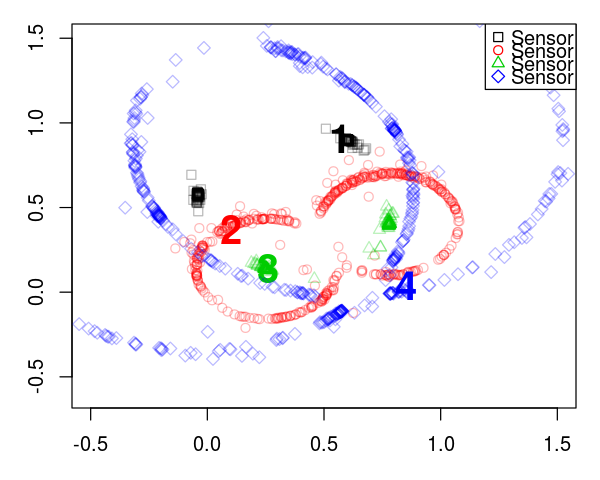

In [143]:
par(mar=c(3,3,1,1))
plot(0,0,xlim=c(-.5,1.5),ylim=c(-.6,1.5),col=0,xlab="",ylab="")
pch_est <- c(0,1,2,5)
## make colors 1:4 transparent
cols <- rgb(t(col2rgb(1:4)),alpha=70,maxColorValue=255)
for(jj in 1:4){
    points(soln[,jj,1],soln[,jj,2],xlab="x_11",ylab="x_12",col=cols[jj],pch=pch_est[jj])
    points(X[jj,1],X[jj,2],col=jj,cex=2,pch=as.character(jj),font=2)
}
legend("topright",paste0("Sensor ",1:4),col=1:4,pch=pch_est)


## Max 100 Iterations

In [144]:
maxit <- 100
for(ii in 1:N){
    init <- runif(8,min=-.5,max=1.5)
    a <- optim(init,likelihood,method="BFGS",Xk=Xk,Y=Y,control=list(maxit=maxit,fnscale=-1))
    soln[ii,,] <- matrix(a$par,ncol=2,byrow=TRUE)
}

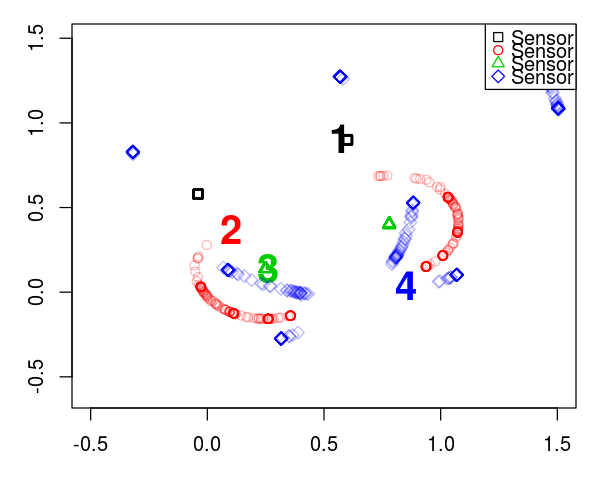

In [145]:
par(mar=c(3,3,1,1))
plot(0,0,xlim=c(-.5,1.5),ylim=c(-.6,1.5),col=0,xlab="",ylab="")
pch_est <- c(0,1,2,5)
## make colors 1:4 transparent
cols <- rgb(t(col2rgb(1:4)),alpha=70,maxColorValue=255)
for(jj in 1:4){
    points(soln[,jj,1],soln[,jj,2],xlab="x_11",ylab="x_12",col=cols[jj],pch=pch_est[jj])
    points(X[jj,1],X[jj,2],col=jj,cex=2,pch=as.character(jj),font=2)
}
legend("topright",paste0("Sensor ",1:4),col=1:4,pch=pch_est)


## Max 1000 Iterations

In [41]:
maxit <- 1000
for(ii in 1:N){
    init <- runif(8,min=-.5,max=1.5)
    a <- optim(init,likelihood,method="BFGS",Xk=Xk,Y=Y,control=list(maxit=maxit,fnscale=-1))
    soln[ii,,] <- matrix(a$par,ncol=2,byrow=TRUE)
}

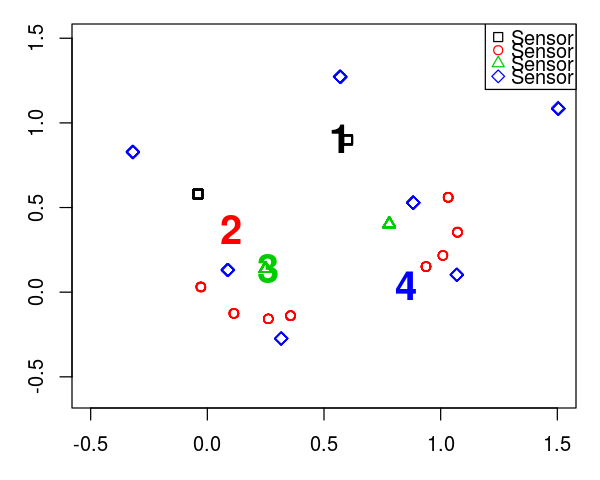

In [42]:
par(mar=c(3,3,1,1))
plot(0,0,xlim=c(-.5,1.5),ylim=c(-.6,1.5),col=0,xlab="",ylab="")
pch_est <- c(0,1,2,5)
## make colors 1:4 transparent
cols <- rgb(t(col2rgb(1:4)),alpha=70,maxColorValue=255)
for(jj in 1:4){
    points(soln[,jj,1],soln[,jj,2],xlab="x_11",ylab="x_12",col=cols[jj],pch=pch_est[jj])
    points(X[jj,1],X[jj,2],col=jj,cex=2,pch=as.character(jj),font=2)
}
legend("topright",paste0("Sensor ",1:4),col=1:4,pch=pch_est)

There appear to be:
- Sensor 1: 2 local maxima
- Sensor 2: 8 local maxima
- Sensor 3: 2 local maxima
- Sensor 4: 7 local maxima

## Which is Global Maximum?

We can select the global maximum by evaluating the likelihood at the limit of each sequence.

In [90]:
a <- apply(soln,1,function(x) likelihood(t(x),Xk,Y))
ix <- which.max(a)

In [91]:
Xhat <- soln[ix,,]

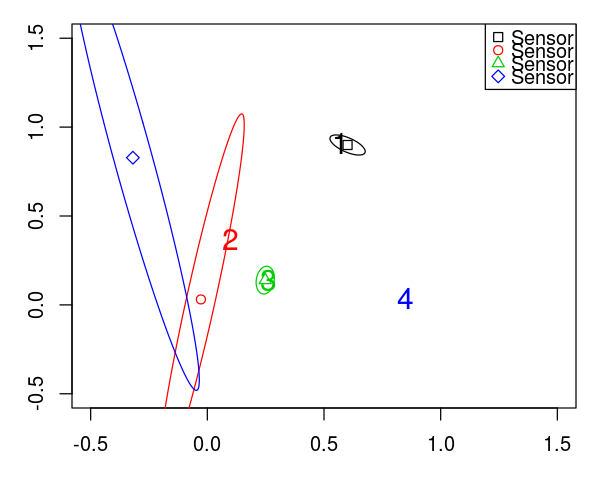

In [92]:
options(repr.plot.width=5,repr.plot.height=4)
pch_est <- c(0,1,2,5)
par(mar=c(3,3,1,1))
plot(Xhat[,1],Xhat[,2],col=1:4,xlab="",ylab="",
    xlim=c(-.5,1.5),ylim=c(-.5,1.5),pch=pch_est)
points(X[1:4,1],X[1:4,2],col=1:4,cex=1.5,pch=as.character(1:4),font=1)
legend("topright",paste0("Sensor ",1:4),col=1:4,pch=pch_est)
for(jj in 1:4){
    v <- avar[(2*jj-1):(2*jj),(2*jj-1):(2*jj)]
    points(ellipse(centre=Xhat[jj,],v,level=0.95),type='l',col=jj)
}

### Important Points
* Local maxima represent a challenge to optimizers such as BFGS. One method to address this challenge is to use many initial values. In nice examples all initial values will converge to the same location. When this does not happen (such as here), you can choose the highest local max.
* The local maxima can have interesting physical interpretations, so it may be a poor idea to simply throw out the local maximum and only report the global max.
* The inverse negative hessian matrix (inverse fisher information) approximation to the parameter variance is **not** appropriate for models which have multiple modes of comparable size or non--elliptical (banana) uncertainties. As the amount of data increases, these situations become less common. Thus the inverse Fisher information is most appropriate in large n / large sample size situations.
* Bayesian approaches are one way to address the challenge of multimodal likelihoods. Bayesian posteriors can give a more refined summary of the highly probable regions of parameter space. These more refined summaries come at the cost of having to specify a prior distribution. Often the computation for these models is more challenging as well. The article from which this data was taken discusses this model from a Bayesian perspective.

** Exercise: ** Analytically compute and code gradient of likelihood and pass as `gr` argument to `optim`. Do you notice any improvement in terms of algorithm speed?

** Exercise: ** Add some sensors to this problem and simulate from the model. Refit the model. Create a situation where one does not have these local maxima.